# Evaluation notebook for models trained on synthetic Binary Choice data


In [1]:
import argparse
import os
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
from ipywidgets import interact, FloatSlider, Button, Output
from IPython.display import HTML, display

from plnn.models import DeepPhiPLNN
from plnn.dataset import get_dataloaders
from plnn.data_generation.plnn_animator import PLNNSimulationAnimator
from plnn.io import load_model_from_directory, load_model_training_metadata
from plnn.loss_functions import select_loss_function

import plnn.pl as pl
from plnn.pl import CHIR_COLOR, FGF_COLOR

In [2]:
SEED = None
BASEDIR = "../../data/trained_models/trained_06_27_24"
BASEOUTDIR = f"../out/bin_dec_models"
SAVE_ANIMATION = False

DATDIRBASE = "../../data/training_data/"
DATDIR = f"{DATDIRBASE}/data_phi1_1a"

MODEL_DIR = "model_phi1_1a_v_mmd1_20240627_193208"
MODEL_NAME = "model_phi1_1a_v_mmd1"

# MODEL_DIR = "model_phi1_1a_v_mmd1_fix_noise_small_20240627_193206"
# MODEL_NAME = "model_phi1_1a_v_mmd1_fix_noise_small"

# BASEDIR = "../../data/trained_models"
# MODEL_DIR = "model_phi1_1a_v_mmd1_20240522_185135"
# MODEL_NAME = "model_phi1_1a_v_mmd1"


In [3]:
# If running as a script, overwrite parameters with command line args

def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__ # type: ignore
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

SCRIPT = not is_notebook()

if SCRIPT:
    import tqdm as tqdm
    parser = argparse.ArgumentParser()
    parser.add_argument("--basedir", type=str, 
                        default="data/trained_models/trained_06_27_24")
    parser.add_argument("--modeldir", type=str, required=True)
    parser.add_argument("--modelname", type=str, required=True)
    parser.add_argument("--datdirbase", type=str, 
                        default="data/training_data/facs")
    parser.add_argument("--datdir", type=str, required=True)
    parser.add_argument("--baseoutdir", type=str, 
                        default="notebooks/out/bin_dec_models")
    parser.add_argument("--save_animation", action='store_true')
    parser.add_argument("--seed", type=int, default=None)
    args = parser.parse_args()

    BASEDIR = args.basedir
    MODEL_DIR = args.modeldir
    MODEL_NAME = args.modelname
    DATDIRBASE = args.datdirbase
    DATDIR = f"{DATDIRBASE}/{args.datdir}"
    BASEOUTDIR = args.baseoutdir
    SAVE_ANIMATION = args.save_animation
    SEED = args.seed

In [4]:
rng = np.random.default_rng(seed=SEED)

INDEX = 'best'
modeldir = f"{BASEDIR}/{MODEL_DIR}"

OUTDIR = f"{BASEOUTDIR}/{MODEL_DIR}"
os.makedirs(OUTDIR, exist_ok=True)

datdir_train = f"{DATDIR}/training"
datdir_valid = f"{DATDIR}/validation"
datdir_test = f"{DATDIR}/validation"  # NOTE: No test data

nsims_train = np.genfromtxt(f"{datdir_train}/nsims.txt", dtype=int)
nsims_valid = np.genfromtxt(f"{datdir_valid}/nsims.txt", dtype=int)
nsims_test = np.genfromtxt(f"{datdir_test}/nsims.txt", dtype=int)

In [5]:
# Load the model
model, hyperparams, idx, model_name, model_fpath = load_model_from_directory(
    modeldir, 
    subdir="states",
    idx=INDEX,
    model_class=DeepPhiPLNN,
    dtype=jnp.float64,
)

# Load the argument dictionary and training run dictionary
logged_args, run_dict = load_model_training_metadata(
    modeldir
)

loss_id = logged_args['loss']

loss_fn = select_loss_function(loss_id)

loss_train = run_dict['loss_hist_train']
loss_valid = run_dict['loss_hist_valid']
sigma_hist = run_dict['sigma_hist']
lr_hist = run_dict['learning_rate_hist']

print(f"Loading model `{model_name}` at epoch {idx} from file: {model_fpath}.")

Loading model `model_phi1_1a_v_mmd1` at epoch 1018 from file: ../../data/trained_models/trained_06_27_24/model_phi1_1a_v_mmd1_20240627_193208/states/model_phi1_1a_v_mmd1_1018.pth.


### Training process metadata
Before examining the inferred landscape, let's look at the training process metadata.

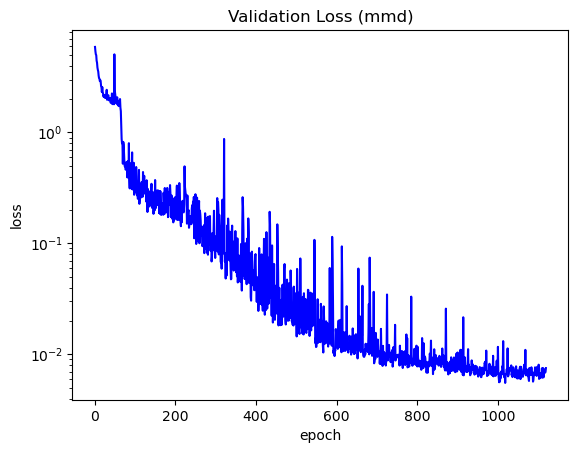

In [6]:
logplot = True
loss_method = logged_args['loss']
optimizer = logged_args['optimizer']

ax = pl.plot_loss_history(
    loss_train, loss_valid,
    log=logplot, 
    title=f"Loss History ({loss_method}, {optimizer})",
)
plt.savefig(f"{OUTDIR}/loss_hist.pdf")
if SCRIPT: plt.close()


ax = pl.plot_learning_rate_history(
    lr_hist, log=False,
)
plt.savefig(f"{OUTDIR}/lr_hist.pdf")
if SCRIPT: plt.close()

ax = pl.plot_sigma_history(
    sigma_hist, log=False,
)
plt.savefig(f"{OUTDIR}/sigma_hist.pdf")
if SCRIPT: plt.close()

ax = pl.plot_training_loss_history(
    loss_train, 
    log=logplot, 
    title=f"Training Loss ({loss_method})",
    color='r', marker=None, linestyle='-',
)
plt.savefig(f"{OUTDIR}/loss_train_hist.pdf")
if SCRIPT: plt.close()

ax = pl.plot_validation_loss_history(
    loss_valid, 
    log=logplot, 
    title=f"Validation Loss ({loss_method})",
    color='b', marker=None, linestyle='-',
)
plt.savefig(f"{OUTDIR}/loss_valid_hist.pdf")
if SCRIPT: plt.close()

## Load training data

In [7]:
train_loader, _, test_loader, train_dset, _, test_dset = get_dataloaders(
    datdir_train, datdir_valid, nsims_train, nsims_valid,
    return_datasets=True,
    include_test_data=True,
    datdir_test=datdir_test, nsims_test=nsims_test, shuffle_test=True,
    batch_size_test=1,
    ncells_sample=model.ncells,
    seed=rng.integers(2**32)
)

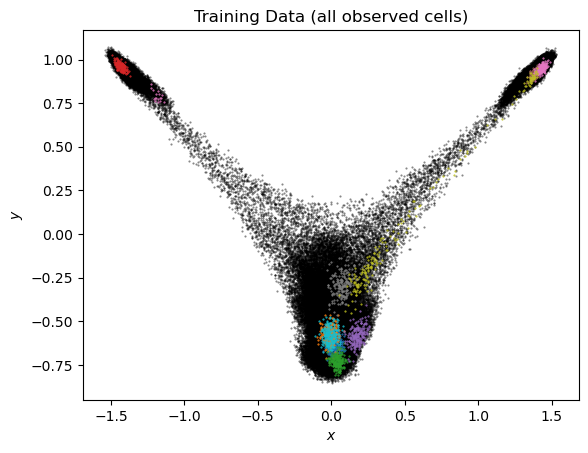

In [8]:
fig, ax = plt.subplots(1, 1)

for d in train_dset:
    x0 = d[0][1]
    ax.plot(x0[:,0], x0[:,1], '.k', markersize=1, alpha=0.5)
x1 = d[1]
ax.plot(x1[:,0], x1[:,1], '.k', markersize=1, alpha=0.5)

idxs = rng.integers(len(train_dset), size=10)

for idx in idxs:
    x0 = train_dset[idx][0][1]
    ax.plot(x0[:,0], x0[:,1], '.', markersize=1, alpha=1)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Training Data (all observed cells)");

plt.savefig(f"{OUTDIR}/training_data.pdf")
if SCRIPT: plt.close()

It will be helpful later to have the domain encapsulating the training data.

In [9]:
xdata = np.vstack([d[0][1] for d in train_dset] + [train_dset[-1][1]])
XYBUFFER = 1.0
XMIN, YMIN = xdata.min(axis=0)
XMAX, YMAX = xdata.max(axis=0)

XMIN, XMAX = XMIN - (XMAX - XMIN) * XYBUFFER, XMAX + (XMAX - XMIN) * XYBUFFER
YMIN, YMAX = YMIN - (YMAX - YMIN) * XYBUFFER, YMAX + (YMAX - YMIN) * XYBUFFER
print("x range:", XMIN, XMAX)
print("y range:", YMIN, YMAX)

x range: -4.607882452510988 4.6046876861628405
y range: -2.778124105182642 2.9960949113207933


In addition, we can look at the coverage of the signaling profiles.

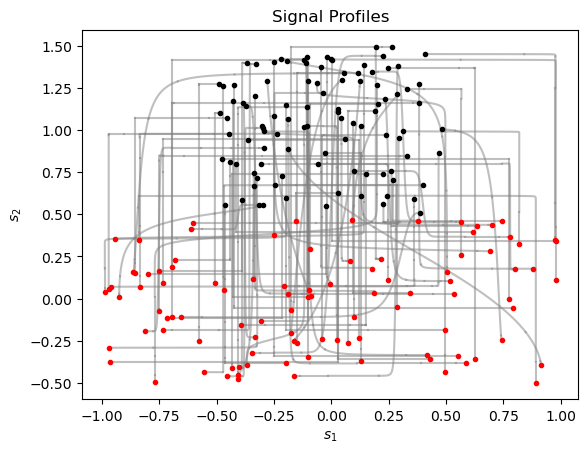

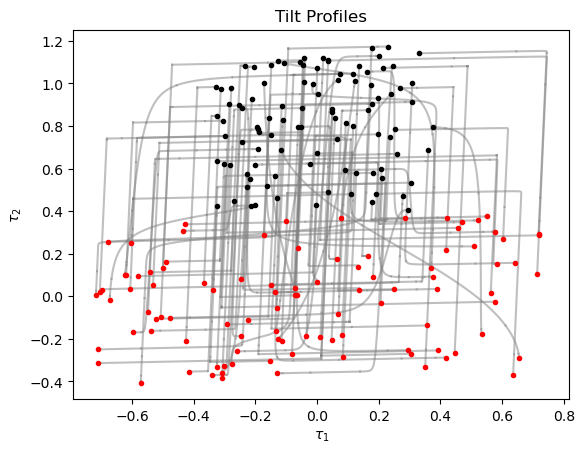

In [10]:
fig1, ax1 = plt.subplots(1, 1)
fig2, ax2 = plt.subplots(1, 1)

TSTART = np.min([d[0][0] for d in train_dset])
TFIN = np.max([d[0][2] for d in train_dset])

k = 101
sigvals_all = []
tiltvals_all = []
signal_parameters_dict = {}  # map tuple of sigparams to start and end time
for d in train_dset:
    t0 = d[0][0]
    t1 = d[0][2]
    sigparams = d[0][-1]
    key = tuple(sigparams.flatten())
    if key in signal_parameters_dict:
        current_val = signal_parameters_dict[key]
        signal_parameters_dict[key] = (min(t0, current_val[0]), 
                                       max(t1, current_val[1]))
    else:
        signal_parameters_dict[key] = (t0, t1)
    ts = np.linspace(t0, t1, k, endpoint=True)
    sigvals = jax.vmap(model.compute_signal, (0, None))(ts, sigparams)
    tiltvals = jax.vmap(model.tilt_module)(sigvals)
    ax1.plot(sigvals[:,0], sigvals[:,1], c='grey', alpha=0.5, zorder=1)
    ax2.plot(tiltvals[:,0], tiltvals[:,1], c='grey', alpha=0.5, zorder=1)
    
    if t0 == TSTART:
        ax1.plot(sigvals[0,0], sigvals[0,1], '.', c='k')
        ax2.plot(tiltvals[0,0], tiltvals[0,1], '.', c='k')
    elif t1 == TFIN:
        ax1.plot(sigvals[-1,0], sigvals[-1,1], '.', c='r')
        ax2.plot(tiltvals[-1,0], tiltvals[-1,1], '.', c='r')
    sigvals_all.append(sigvals)
    tiltvals_all.append(tiltvals)

ax1.set_title("Signal Profiles")
ax1.set_xlabel("$s_1$")
ax1.set_ylabel("$s_2$")

ax2.set_title("Tilt Profiles")
ax2.set_xlabel("$\\tau_1$")
ax2.set_ylabel("$\\tau_2$")

sigvals_all = np.vstack(sigvals_all)
tiltvals_all = np.vstack(tiltvals_all)

plt.figure(fig1)
plt.savefig(f"{OUTDIR}/signal_profile_coverage.pdf")
if SCRIPT: plt.close()

plt.figure(fig2)
plt.savefig(f"{OUTDIR}/tilt_profile_coverage.pdf")
if SCRIPT: plt.close()

In [11]:
S12BUFFER = 2.0
S1MIN, S2MIN = np.min(sigvals_all, axis=0)
S1MAX, S2MAX = np.max(sigvals_all, axis=0)
S1MIN, S1MAX = S1MIN - (S1MAX - S1MIN) * S12BUFFER, \
               S1MAX + (S1MAX - S1MIN) * S12BUFFER
S2MIN, S2MAX = S2MIN - (S2MAX - S2MIN) * S12BUFFER, \
               S2MAX + (S2MAX - S2MIN) * S12BUFFER

print("s1 range:", S1MIN, S1MAX)
print("s2 range:", S2MIN, S2MAX)

TAU12BUFFER = 2.0
TAU1MIN, TAU2MIN = np.min(tiltvals_all, axis=0)
TAU1MAX, TAU2MAX = np.max(tiltvals_all, axis=0)
TAU1MIN, TAU1MAX = TAU1MIN - (TAU1MAX - TAU1MIN) * TAU12BUFFER, \
                   TAU1MAX + (TAU1MAX - TAU1MIN) * TAU12BUFFER
TAU2MIN, TAU2MAX = TAU2MIN - (TAU2MAX - TAU2MIN) * TAU12BUFFER, \
                   TAU2MAX + (TAU2MAX - TAU2MIN) * TAU12BUFFER

print("tau1 range:", TAU1MIN, TAU1MAX)
print("tau2 range:", TAU2MIN, TAU2MAX)

s1 range: -4.918445504371568 4.9093435779820425
s2 range: -4.488142593274193 5.485518560832326
tau1 range: -3.641642474256423 3.6700837277459204
tau2 range: -3.56260228418117 4.331261250648159


## Comparison of true and inferred ensemble trajectories


In [12]:
key = jrandom.PRNGKey(123)

nsamps = 4
test_indices = rng.integers(0, len(test_dset), size=4)

@eqx.filter_jit
def compute_loss(model, x, y, loss_fn, key):
    t0, y0, t1, sigparams = x
    y_pred = model(t0, t1, y0, sigparams, key)
    return loss_fn(y_pred, y), y_pred

losses = np.zeros(nsamps)
x1obs_samples = []
x1sim_samples = []
iterloader = iter(test_loader)
for i in range(nsamps):
    inputs, x1obs = next(iterloader)
    inputs, x1obs = test_dset[test_indices[i]]
    t0, x0, t1, sigparams = inputs
    inputs = (jnp.array([v], dtype=jnp.float64) for v in inputs)
    x1obs = jnp.array([x1obs])
    key, subkey = jrandom.split(key, 2)
    model
    loss, x1sim = compute_loss(model, inputs, x1obs, loss_fn, subkey)
    losses[i] = loss
    x1obs_samples.append(x1obs[0])
    x1sim_samples.append(x1sim[0])

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(6,6))

for i in range(len(losses)):
    ax = axes.flatten()[i]
    ax.plot(
        x1obs_samples[i][:,0], x1obs_samples[i][:,1], 
        color='k', marker='.', linestyle='none',
        label="obs"
    )
    ax.plot(
        x1sim_samples[i][:,0], x1sim_samples[i][:,1], 
        color='r', marker='.', linestyle='none',
        label="sim",
        alpha=0.9
    )
    ax.legend()
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_title(f"Loss: {losses[i]:.4g}")

plt.tight_layout()
plt.savefig(f"{OUTDIR}/sample_comparisons.pdf")
if SCRIPT: plt.close()

## Construct the inferred signal mapping

In [14]:
A = model.get_parameters()['tilt.w'][0]
b = model.get_parameters()['tilt.b'][0]
if b is None:
    b = 0.

print("A:\n", A)
print("b:", b)

def signal_to_tilt(sig):
    if sig.ndim == 1:
        return A@sig + b
    return (A@sig.T + b).T
    
def tilt_to_signal(tilt):
    if tilt.ndim == 1:
        return np.linalg.solve(A, tilt - b)
    return np.linalg.solve(A, tilt.T - b).T

A:
 [[0.72707771 0.02423672]
 [0.02211272 0.78061972]]
b: 0.0


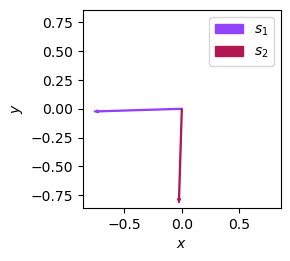

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.set_aspect('equal')

scale = np.max(np.abs(A))

ax.arrow(
    0, 0, -A[0,0], -A[1,0], 
    width=0.01*scale, 
    fc=CHIR_COLOR, ec=CHIR_COLOR,
    label="$s_1$"
)

ax.arrow(
    0, 0, -A[0,1], -A[1,1], 
    width=0.01*scale, 
    fc=FGF_COLOR, ec=FGF_COLOR,
    label="$s_2$"
)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_xlim([-scale*1.1, scale*1.1])
ax.set_ylim([-scale*1.1, scale*1.1])

ax.legend();

plt.tight_layout()
plt.savefig(f"{OUTDIR}/signal_direction.pdf")
if SCRIPT: plt.close()

interactive(children=(FloatSlider(value=0.0, description='sig1', max=4.9093435779820425, min=-4.91844550437156…

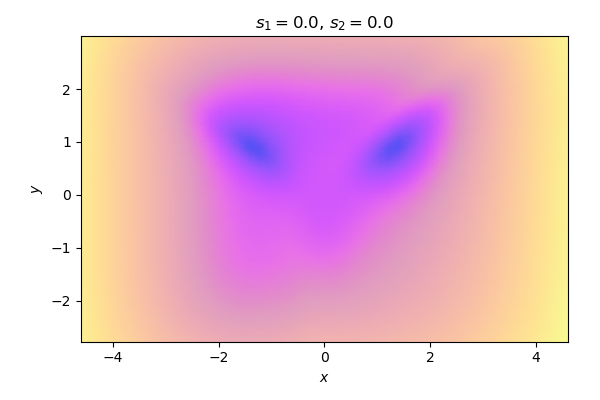

In [16]:
%matplotlib widget

S1 = 0.
S2 = 0.

ax = model.plot_phi(
    signal=[S1, S2],  # CHIR, FGF
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    show=True,
    include_cbar=False,
    title=f"$s_1={S1:.1f}$, $s_2={S2:.1f}$"
);

def update_plot(sig1, sig2):
    plt.cla()
    model.plot_phi(
        signal=[sig1, sig2],
        xrange=[XMIN, XMAX],
        yrange=[YMIN, YMAX],
        show=True,
        include_cbar=False,
        ax=ax,
    )
    ax.set_title(f"$s_1={sig1:.1f}$, $s_2={sig2:.1f}$")

interact(
    update_plot, 
    sig1=FloatSlider(
        value=0., min=S1MIN, max=S1MAX, step=0.1, 
        description='sig1',
    ),
    sig2=FloatSlider(
        value=0., min=S2MIN, max=S2MAX, step=0.1, 
        description='sig2',
    )
);

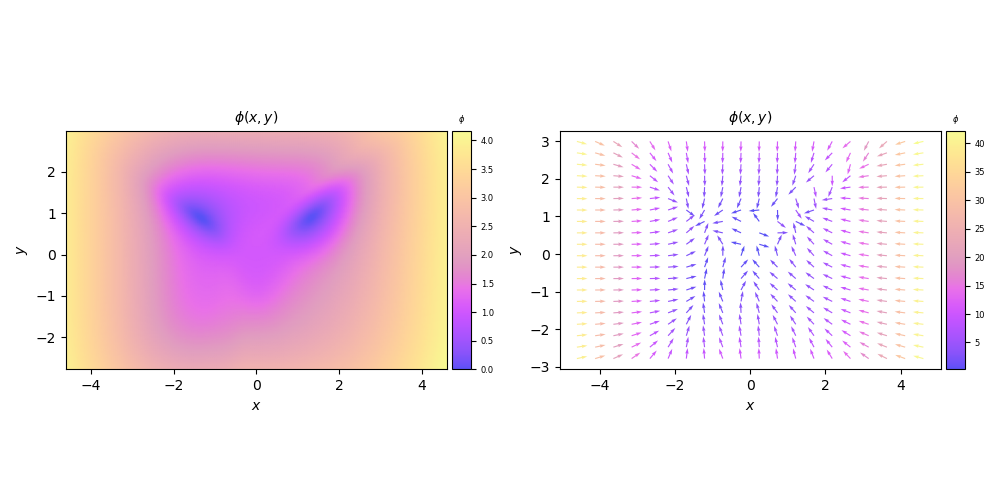

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

pl.plot_phi(
    model,
    res=200,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    equal_axes=True,
    ax=axes[0],
    show=True,
)

pl.plot_f(
    model,
    res=20,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    equal_axes=True,
    ax=axes[1],
    show=True,
)

if not SCRIPT: plt.show()
plt.tight_layout()

plt.savefig(f"{OUTDIR}/landscape_and_field.pdf")
if SCRIPT: plt.close()

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

pl.plot_phi(
    model,
    res=200,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    equal_axes=True,
    ax=axes[0,0],
    title="$\\boldsymbol{\\tau}=[0,0]^T$",
    show=True
)

pl.plot_phi(
    model,
    res=200,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    tilt=[1, 0],
    equal_axes=True,
    ax=axes[0,1],
    title="$\\boldsymbol{\\tau}=[1,0]^T$",
    show=True
)

pl.plot_phi(
    model,
    res=200,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    tilt=[0, 1],
    equal_axes=True,
    ax=axes[1,0],
    title="$\\boldsymbol{\\tau}=[0,1]^T$",
    show=True
)

pl.plot_phi(
    model,
    res=200,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    tilt=[1, 1],
    equal_axes=True,
    ax=axes[1,1],
    title="$\\boldsymbol{\\tau}=[1,1]^T$",
    show=True
)

plt.tight_layout()
plt.savefig(f"{OUTDIR}/landscape_4_tilts.pdf")
if SCRIPT: plt.close()

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

pl.plot_phi(
    model,
    res=200,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    equal_axes=True,
    ax=axes[0,0],
    title="$\\boldsymbol{s}=[0,0]^T$",
    show=True
)

pl.plot_phi(
    model,
    signal=[1, 0],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=200,
    equal_axes=True,
    ax=axes[0,1],
    title="$\\boldsymbol{s}=[1,0]^T$",
    show=True
)

pl.plot_phi(
    model,
    signal=[0, 1],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=200,
    equal_axes=True,
    ax=axes[1,0],
    title="$\\boldsymbol{s}=[0,1]^T$",
    show=True
)

pl.plot_phi(
    model,
    signal=[1, 1],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    res=200,
    equal_axes=True,
    ax=axes[1,1],
    title="$\\boldsymbol{s}=[1,1]^T$",
    show=True,
)

plt.tight_layout();
plt.savefig(f"{OUTDIR}/landscape_4_signals.pdf")
if SCRIPT: plt.close()

## Simulation

In [20]:
# import jax.tree_util as jtu
# import equinox as eqx
# model = eqx.tree_at(lambda m: m.logsigma, model, jnp.log(0.3))

key = jrandom.PRNGKey(rng.integers(2**32))

idx = rng.integers(len(train_dset))
sigparams = train_dset[idx][0][-1]
_, tfin = signal_parameters_dict[tuple(sigparams.flatten())]

ncells = 200
dtsave1 = tfin/100
dtsave2 = tfin/10

# Initial condition
key, subkey = jrandom.split(key, 2)
x0 = jrandom.normal(subkey, [ncells, 2])

# Simulate particles in the landscape
key, subkey = jrandom.split(key, 2)
ts_all, xs_all, sigs_all, ps_all = model.run_landscape_simulation(
    x0, tfin, [dtsave1, dtsave2], sigparams, subkey
)

ts, ts_saved = ts_all
xs, xs_saved = xs_all
sigs, sigs_saved = sigs_all
ps, ps_saved = ps_all

In [21]:
from plnn.vectorfields import find_minima_along_tilt_trajectory
from plnn.vectorfields import check_minima_trajectories_for_bifurcations
from plnn.vectorfields import estimate_minima

minima = find_minima_along_tilt_trajectory(
    model, ps,
    ndivisions=20,
    tol=1e-3,
    x0_range=[[XMIN, XMAX],[YMIN,YMAX]],
    method="BFGS",
    opt_tol=1e-5,
)

bifs, bif_idxs, bif_tilts, bif_mins = check_minima_trajectories_for_bifurcations(
    ps, minima
)

Identified 2 potential bifurcation points...
At time t=86.0:
	tau=(0.112, 0.633)
	mins0:
		[-1.29127568  0.81801985]
		[-1.24857276 -0.93295889]
		[-0.03271192 -0.52378209]
		[1.25341851 0.80324272]
	mins1:
		[-1.30376018  0.83458673]
		[-0.03967215 -0.4446371 ]
		[1.26541908 0.82065298]
At time t=88.0:
	tau=(0.0994, 0.227)
	mins0:
		[-1.3337975   0.87447424]
		[1.29490035 0.86249223]
		[-0.10947564 -0.14077724]
	mins1:
		[-1.36585625  0.91744619]
		[1.32740651 0.90727464]
Starting points for potential bifurcations:
 [[-1.24857276 -0.93295889]
 [-0.10947564 -0.14077724]]


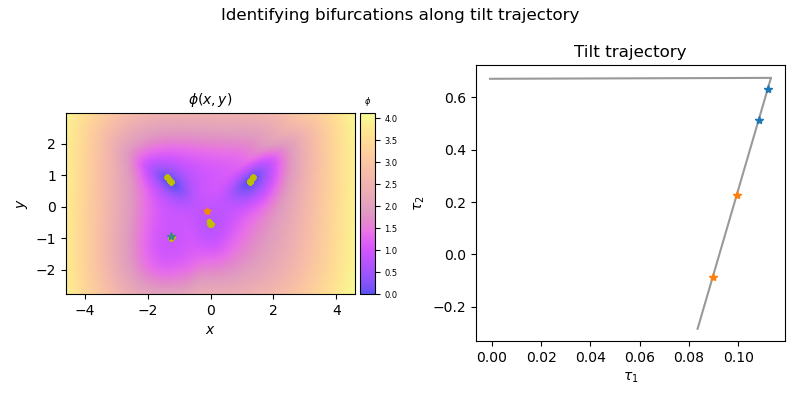

In [22]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))

print(f"Identified {len(bif_idxs)} potential bifurcation points...")
for i in range(len(bif_idxs)):
    tau0, tau1 = bif_tilts[i]
    mins0, mins1 = bif_mins[i]
    print(f"At time t={ts[bif_idxs[i]]}:")
    print(f"\ttau=({', '.join([f'{x:.3g}' for x in tau0])})")
    print(f"\tmins0:")
    for m in mins0:
        print(f"\t\t{m}")
    print(f"\tmins1:")
    for m in mins1:
        print(f"\t\t{m}")
print(f"Starting points for potential bifurcations:\n", bifs)

pl.plot_phi(
    model,
    tilt=ps[0],
    res=200,
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    equal_axes=True,
    ax=ax1,
    show=True,
)

for i in range(len(minima)):
    ax1.plot(minima[i][:,0], minima[i][:,1], '.y');

ax2.plot(ps[:,0], ps[:,1], '-', color='grey', alpha=0.8)

for bifmin, tilt in zip(bifs, bif_tilts):
    l, = ax1.plot(*bifmin, '*', alpha=0.7)
    color = l.get_color()
    ax2.plot(*tilt[0], '*', c=color)
    ax2.plot(*tilt[1], '*', c=color)

ax2.set_xlabel(f"$\\tau_1$")
ax2.set_ylabel(f"$\\tau_2$")
ax2.set_title(f"Tilt trajectory")

fig.suptitle("Identifying bifurcations along tilt trajectory")

plt.tight_layout()

plt.savefig(f"{OUTDIR}/param_profile_bif_finding.pdf")
if SCRIPT: plt.close()

In [23]:
from cont.plnn_bifurcations import get_plnn_bifurcation_curves

landscape_tex = "$\phi$"

bifcurves, bifcolors = get_plnn_bifurcation_curves(
    model, 
    num_starts=50,
    p1lims=[TAU1MIN, TAU1MAX],
    p2lims=[TAU2MIN, TAU2MAX],
    xstarts=[[x, None] for x in bifs],
    xlims=[XMIN, XMAX],
    ylims=[YMIN, YMAX],
    color=None,
    maxiter=10000,
    ds=1e-3,
    min_ds=1e-8,
    max_ds=1e-2,
    max_delta_p=1e-2,
    rho=1e-1,
    seed=rng.integers(2**32),
    verbosity=0,
)

# Filter out singleton bifurcation curves and remove initial estimate point
keepidxs = [i for i in range(len(bifcurves)) if len(bifcurves[i]) > 1]
bifcurves = [bc[1:] for bc in bifcurves if len(bc) > 1]
bifcolors = [bifcolors[i] for i in keepidxs]


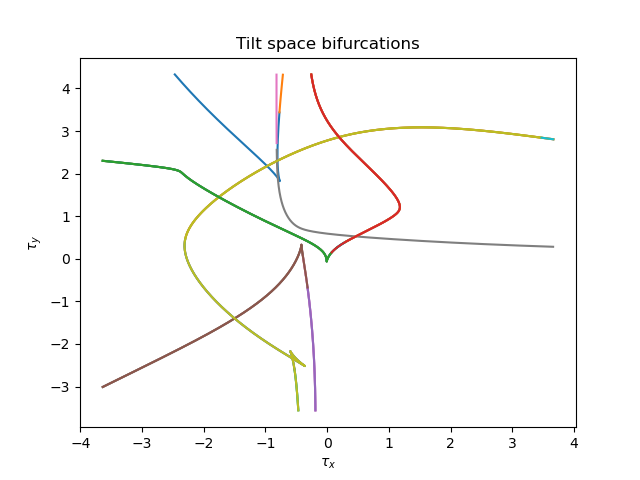

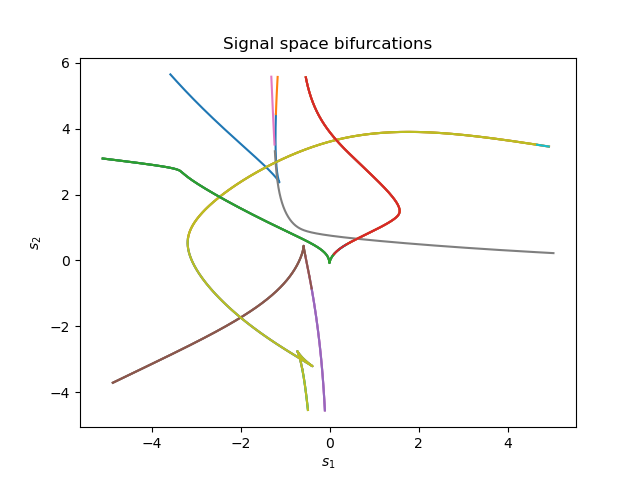

In [24]:
fig, ax = plt.subplots(1, 1)
for i in range(len(bifcurves)):
    curve = bifcurves[i]
    color = bifcolors[i]
    ax.plot(curve[:,0], curve[:,1], color=color, linestyle='-')
ax.set_xlabel("$\\tau_x$")
ax.set_ylabel("$\\tau_y$");
ax.set_title("Tilt space bifurcations");

plt.savefig(f"{OUTDIR}/tilt_space_bifs.pdf")
if SCRIPT: plt.close()


fig, ax = plt.subplots(1, 1)
for i in range(len(bifcurves)):
    curve = bifcurves[i]
    curve = tilt_to_signal(curve)
    color = bifcolors[i]
    ax.plot(curve[:,0], curve[:,1], color=color, linestyle='-')
ax.set_xlabel("$s_1$")
ax.set_ylabel("$s_2$");
ax.set_title("Signal space bifurcations");

plt.savefig(f"{OUTDIR}/signal_space_bifs.pdf")
if SCRIPT: plt.close()

In [25]:
num_ts = 10
key_list = []
x_bif_points_traj_list = []
tilt_bif_points_list = []
for key in tqdm.tqdm(signal_parameters_dict):
    sigparams = np.array(key).reshape([2,-1])
    t0, t1 = signal_parameters_dict[key]
    assert sigparams.shape == (2,4), "Wrong shape for sigparams"
    ts_arr = np.linspace(t0, t1, num_ts, endpoint=True)
    sigtraj = jax.vmap(model.compute_signal, (0, None))(ts_arr, sigparams)
    tilttraj = signal_to_tilt(sigtraj)
    
    minima_along_traj = find_minima_along_tilt_trajectory(
        model, tilttraj,
        ndivisions=5,
        n=4,
        tol=1e-3,
        x0_range=[[XMIN, XMAX],[YMIN,YMAX]],
        method="BFGS",
        opt_tol=1e-5,
    )

    bifs, bif_idxs, bif_tilts, bif_mins = check_minima_trajectories_for_bifurcations(
        tilttraj, minima_along_traj
    )
    key_list.append(key)
    x_bif_points_traj_list.append(bifs)
    tilt_bif_points_list.append(bif_tilts)

# Pool bifurcation points
bifs_all = np.vstack([b for b in x_bif_points_traj_list if len(b) > 0])

  0%|          | 0/100 [00:00<?, ?it/s]

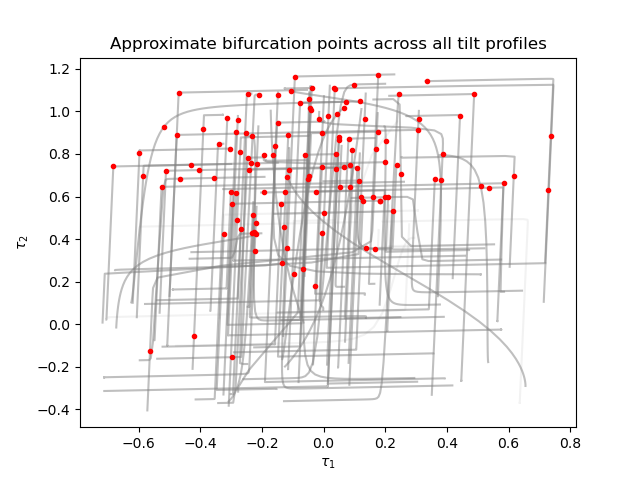

In [26]:
fig, ax = plt.subplots(1, 1)

num_ts = 101
for key, bifs_set in zip(key_list, tilt_bif_points_list):
    t0, t1 = signal_parameters_dict[key]
    ts = np.linspace(t0, t1, num_ts, endpoint=True)
    sigparams = np.array(key).reshape([2,-1])
    sigvals = jax.vmap(model.compute_signal, (0, None))(ts, sigparams)
    tiltvals = jax.vmap(model.tilt_module)(sigvals)
    alpha = 0.5 if len(bifs_set) > 0 else 0.1
    ax.plot(tiltvals[:,0], tiltvals[:,1], c='grey', alpha=alpha, zorder=1)
    for tilt0, tilt1 in bifs_set:
        ax.plot(*tilt0, '.', color='r')
    
ax.set_xlabel(f"$\\tau_1$")
ax.set_ylabel(f"$\\tau_2$")
ax.set_title(f"Approximate bifurcation points across all tilt profiles");

plt.savefig(f"{OUTDIR}/pooled_tilt_profiles_approx_bifpoints.pdf")
if SCRIPT: plt.close()

In [27]:
landscape_tex = "$\phi$"

n_additional_starts = 150

bifcurves, bifcolors, aux_info = get_plnn_bifurcation_curves(
    model, 
    num_starts=len(bifs_all) + n_additional_starts,
    p1lims=[TAU1MIN, TAU1MAX],
    p2lims=[TAU2MIN, TAU2MAX],
    xstarts=[[x, None] for x in bifs_all],
    xlims=[XMIN, XMAX],
    ylims=[YMIN, YMAX],
    color=None,
    maxiter=10000,
    ds=1e-3,
    min_ds=1e-8,
    max_ds=1e-2,
    max_delta_p=1e-2,
    rho=1e-1,
    return_aux_info=True,
    seed=rng.integers(2**32),
    verbosity=0,
)

# Filter out singleton bifurcation curves and remove initial estimate point
keepidxs = [i for i in range(len(bifcurves)) if len(bifcurves[i]) > 1]
bifcurves_plt = [bc[1:] for bc in bifcurves if len(bc) > 1]
bifcolors_plt = [bifcolors[i] for i in keepidxs]


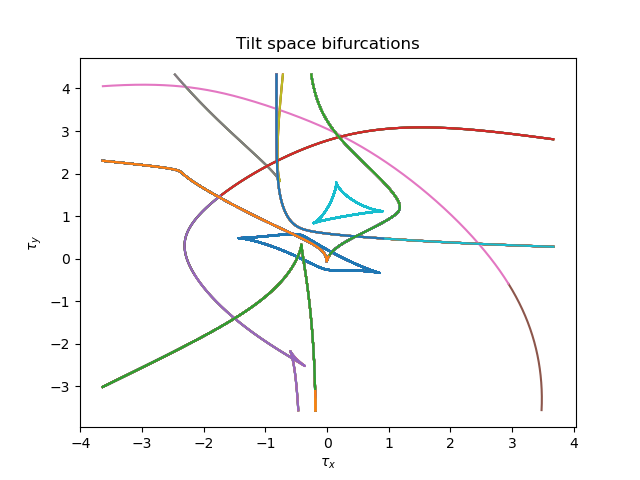

In [28]:
fig, ax = plt.subplots(1, 1)

for i in range(len(bifcurves_plt)):
    curve = bifcurves_plt[i]
    color = bifcolors_plt[i]
    ax.plot(curve[:,0], curve[:,1], color=color, linestyle='-', alpha=1)
ax.set_xlabel("$\\tau_x$")
ax.set_ylabel("$\\tau_y$");
ax.set_title("Tilt space bifurcations");

# plt.savefig(f"{OUTDIR}/tilt_space_bifurcations")


In [29]:
len(aux_info)

279

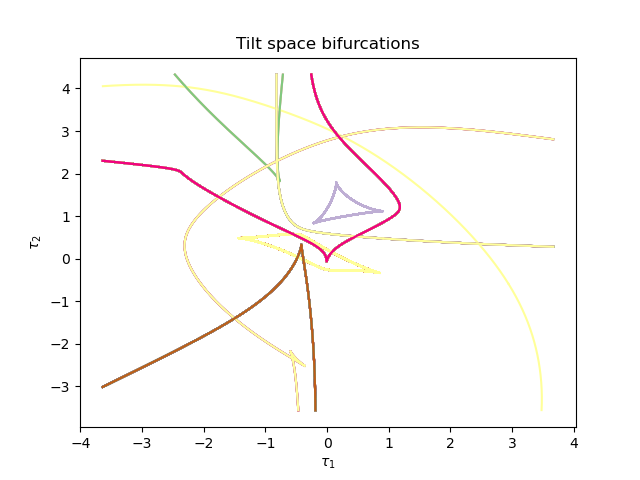

In [30]:
fig1, ax1 = plt.subplots(1, 1)
fig2, ax2 = plt.subplots(1, 1)
fig3, ax3 = plt.subplots(1, 1)

for ax in [ax1, ax2, ax3]:
    ax.set_prop_cycle(color=plt.get_cmap('Accent').colors[:-1])

for i in range(len(aux_info)):
    info = aux_info[i]
    if 'xs_path_fwd' in info:
        xpath_fwd = info['xs_path_fwd'][1:]
        xpath_rev = info['xs_path_rev'][1:]
        ppath_fwd = info['ps_path_fwd'][1:]
        ppath_rev = info['ps_path_rev'][1:]
        spath_fwd = tilt_to_signal(ppath_fwd)
        spath_rev = tilt_to_signal(ppath_rev)
        l1, = ax1.plot(
            xpath_fwd[:,0], xpath_fwd[:,1], 
            color=None, linestyle='-', alpha=1,
        )
        color = l1.get_color()
        ax1.plot(
            xpath_rev[:,0], xpath_rev[:,1], 
            color=color, linestyle='-', alpha=1
        )
        ax2.plot(
            ppath_fwd[:,0], ppath_fwd[:,1], 
            color=color, linestyle='-', alpha=1
        )
        ax2.plot(
            ppath_rev[:,0], ppath_rev[:,1], 
            color=color, linestyle='-', alpha=1
        )
        ax3.plot(
            spath_fwd[:,0], spath_fwd[:,1], 
            color=color, linestyle='-', alpha=1
        )
        ax3.plot(
            spath_rev[:,0], spath_rev[:,1], 
            color=color, linestyle='-', alpha=1
        )
ax1.set_xlabel("$x$")
ax1.set_ylabel("$y$");
ax1.set_title("Bifurcating extrema");

ax2.set_xlabel("$\\tau_1$")
ax2.set_ylabel("$\\tau_2$")
ax2.set_title("Tilt space bifurcations");

ax3.set_xlabel("$s_1$")
ax3.set_ylabel("$s_2$")
ax3.set_title("Signal space bifurcations");

plt.figure(fig1)
plt.savefig(f"{OUTDIR}/bifdiag_extrema.pdf")
if SCRIPT: plt.close()
plt.figure(fig2)
plt.savefig(f"{OUTDIR}/bifdiag_tilts.pdf")
if SCRIPT: plt.close()
plt.figure(fig3)
plt.savefig(f"{OUTDIR}/bifdiag_signals.pdf")
if SCRIPT: plt.close()

In [31]:
# k=100
# bifs_all = []
# for key in tqdm.tqdm(signal_parameters_dict):
#     sigparams = np.array(key).reshape([2,-1])
#     t0, t1 = signal_parameters_dict[key]
#     assert sigparams.shape == (2,4), "Wrong shape for sigparams"
#     ts = np.linspace(t0, t1, k, endpoint=True)
#     sigtraj = jax.vmap(model.compute_signal, (0, None))(ts, sigparams)
#     tilttraj = signal_to_tilt(sigtraj)
    
#     minima_along_traj = find_minima_along_tilt_trajectory(
#         model, tilttraj,
#         ndivisions=5,
#         tol=1e-3,
#         x0_range=[[XMIN, XMAX],[YMIN,YMAX]],
#         method="BFGS",
#         opt_tol=1e-5,
#     )

#     bifs, bif_idxs, bif_tilts, bif_mins = check_minima_trajectories_for_bifurcations(
#         tilttraj, minima_along_traj
#     )
#     bifs_all.append(bifs)

# bifs_all = np.vstack([b for b in bifs_all if len(b) > 0])

# fig, ax = plt.subplots(1, 1)
# ax.plot(bifs_all[:,0], bifs_all[:,1], '.');

In [32]:
mins_cache = None

In [33]:
xrange = [XMIN, XMAX]
yrange = [YMIN, YMAX]

taux_lims = [TAU1MIN, TAU1MAX]
tauy_lims = [TAU2MIN, TAU2MAX]
nx = 10
ny = 10

taux_arr = np.linspace(*taux_lims, nx)
tauy_arr = np.linspace(*tauy_lims, ny)
tauxs, tauys = np.meshgrid(taux_arr, tauy_arr)

mins_cache = {}

for i, taux in tqdm.tqdm(
    enumerate(taux_arr), total=len(taux_arr), 
    desc="outer loop"
):
    for j, tauy in tqdm.tqdm(
        enumerate(tauy_arr), total=len(tauy_arr), 
        desc="inner loop", leave=False
    ):
        mins = estimate_minima(
            model, 
            np.array([taux, tauy]),
            n=5, 
            d=2, 
            x0=None, 
            tol=1e-3,
            method="BFGS",
            opt_tol=1e-5,
            x0_range=[xrange, yrange],
            sample_x0=False,
            rng=None, 
            seed=None,
        )
        mins_cache[taux, tauy] = mins

outer loop:   0%|          | 0/10 [00:00<?, ?it/s]

inner loop:   0%|          | 0/10 [00:00<?, ?it/s]

inner loop:   0%|          | 0/10 [00:00<?, ?it/s]

inner loop:   0%|          | 0/10 [00:00<?, ?it/s]

inner loop:   0%|          | 0/10 [00:00<?, ?it/s]

inner loop:   0%|          | 0/10 [00:00<?, ?it/s]

inner loop:   0%|          | 0/10 [00:00<?, ?it/s]

inner loop:   0%|          | 0/10 [00:00<?, ?it/s]

inner loop:   0%|          | 0/10 [00:00<?, ?it/s]

inner loop:   0%|          | 0/10 [00:00<?, ?it/s]

inner loop:   0%|          | 0/10 [00:00<?, ?it/s]

Button(description='Halt', style=ButtonStyle())

Output()

Button(description='Reset limits', style=ButtonStyle())

Output()

interactive(children=(FloatSlider(value=-1.6, description='sig1', max=5.551209646554041, min=-5.68990985259333…

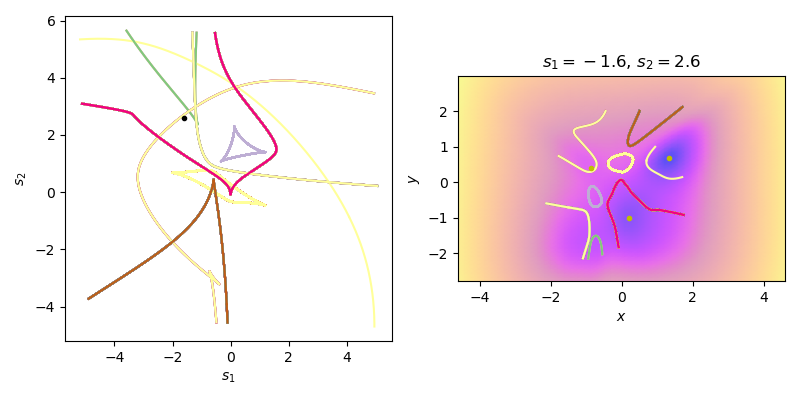

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
ax1 = axes[0]
ax2 = axes[1]

sig1 = -1.60
sig2 = 2.58

extra_xy_to_check = []

ax1.set_prop_cycle(color=plt.get_cmap('Accent').colors[:-1])
for i in range(len(aux_info)):
    info = aux_info[i]
    if 'xs_path_fwd' in info:
        xpath_fwd = info['xs_path_fwd'][1:]
        xpath_rev = info['xs_path_rev'][1:]
        ppath_fwd = info['ps_path_fwd'][1:]
        ppath_rev = info['ps_path_rev'][1:]
        spath_fwd = tilt_to_signal(ppath_fwd)
        spath_rev = tilt_to_signal(ppath_rev)
        l1, = ax1.plot(
            spath_fwd[:,0], spath_fwd[:,1], 
            color=None, linestyle='-', alpha=1,
        )
        color = l1.get_color()
        ax1.plot(
            spath_rev[:,0], spath_rev[:,1], 
            color=color, linestyle='-', alpha=1
        )

sigmarker, = ax1.plot([sig1], [sig2], '.k')

ax1.set_xlabel("$s_1$")
ax1.set_ylabel("$s_2$")

mins = estimate_minima(
    model, 
    signal_to_tilt(np.array([sig1, sig2], dtype=float)), 
    n=10, 
    d=2, 
    x0=None, 
    tol=1e-3,
    method="BFGS",
    opt_tol=1e-5,
    x0_range=[[XMIN, XMAX],[YMIN, YMAX]],
    sample_x0=False,
    rng=None, 
    seed=None,
)

if mins_cache is None:
    mins_cache = {}
    mins_cache[(sig1, sig2)] = mins
ax2.plot(mins[:,0], mins[:,1], '.')

model.plot_phi(
    signal=[sig1, sig2],
    xrange=[XMIN, XMAX],
    yrange=[YMIN, YMAX],
    show=True,
    # lognormalize=False,
    include_cbar=False,
    ax=ax2,
)


def update_plot(sig1, sig2):
    plt.sca(ax1)
    sigmarker.set_data([sig1], [sig2])
    
    plt.sca(ax2)
    plt.cla()
    model.plot_phi(
        signal=[sig1, sig2],
        xrange=[XMIN, XMAX],
        yrange=[YMIN, YMAX],
        # lognormalize=False,
        show=True,
        include_cbar=False,
        ax=ax2,
    )
    ax2.set_prop_cycle(color=plt.get_cmap('Accent').colors[:-1])
    for i in range(len(aux_info)):
        info = aux_info[i]
        if 'xs_path_fwd' not in info:
            continue
        xpath_fwd = info['xs_path_fwd'][1:]
        xpath_rev = info['xs_path_rev'][1:]
        l, = ax2.plot(
            xpath_fwd[:,0], xpath_fwd[:,1], color=None, 
            linestyle='-', alpha=1.0
        )
        ax2.plot(
            xpath_rev[:,0], xpath_rev[:,1], 
            color=l.get_color(), 
            linestyle='-', alpha=1.0
        )
        
    mins = mins_cache.get((sig1, sig2), None)
    if mins is None:
        mins = estimate_minima(
            model, 
            signal_to_tilt(np.array([sig1, sig2], dtype=float)), 
            n=4, 
            d=2, 
            x0=None, 
            tol=1e-3,
            method="BFGS",
            opt_tol=1e-5,
            x0_range=[[XMIN, XMAX],[YMIN,YMAX]],
            sample_x0=False,
            extra_x0=extra_xy_to_check,
            rng=None, 
            seed=None,
        )
        mins_cache[(sig1, sig2)] = mins

    if len(mins) > 0:
        ax2.plot(mins[:,0], mins[:,1], 'y.')
        ax2.set_title(f"$s_1={sig1:.1f}$, $s_2={sig2:.1f}$")

sig1slider = FloatSlider(
    value=sig1, min=ax1.get_xlim()[0], max=ax1.get_xlim()[1], step=0.1, 
    description='sig1',
)
sig2slider = FloatSlider(
    value=sig2, min=ax1.get_ylim()[0], max=ax1.get_ylim()[1], step=0.1, 
    description='sig2',
)


def onclick(event):
    global sig1, sig2
    xclick, yclick = event.xdata, event.ydata
    if event.inaxes == ax1:
        sig1, sig2 = xclick, yclick
        update_plot(sig1, sig2)
        sig1slider.value = sig1
        sig2slider.value = sig2
    elif event.inaxes == ax2:
        extra_xy_to_check.append([xclick, yclick])
    return (xclick, yclick)
cid = fig.canvas.mpl_connect('button_press_event', onclick)

###############
##  Buttons  ##
###############

button1 = Button(description="Halt")
output1 = Output()
display(button1, output1)
def on_button1_clicked(b):
    with output1:
        fig.canvas.mpl_disconnect(cid)
button1.on_click(on_button1_clicked)

button2 = Button(description="Reset limits")
output2 = Output()
display(button2, output2)
ax1_xlims_orig = ax1.get_xlim()
ax1_ylims_orig = ax1.get_ylim()
def on_button2_clicked(b):
    with output2:
        ax1.set_xlim(*ax1_xlims_orig)
        ax1.set_ylim(*ax1_ylims_orig)
button2.on_click(on_button2_clicked)

# button2 = Button(description="Reset limits")
# output2 = Output()
# display(button2, output2)
# def on_button2_clicked(b):
#     with output2:
#         pass
# button2.on_click(on_button2_clicked)


################################################################
################################################################

interact(
    update_plot, 
    sig1=sig1slider,
    sig2=sig2slider,
);

In [36]:
plt.figure()
plt.close()

duration = 10
dpi = 200
grid_size = 1

animator = PLNNSimulationAnimator(
    model, sigparams,
    ts, xs, sigs, ps, 
    ts_saved, xs_saved, sigs_saved, ps_saved, 
    xlims=[XMIN, XMAX], ylims=[YMIN, YMAX],
    p0lims=[TAU1MIN, TAU1MAX],
    p1lims=[TAU2MIN, TAU2MAX],
    minima=minima,
    bifcurves=bifcurves,
    bifcolors=bifcolors,
    view_init=(45, 30),
    sig_names=['$s_1$', '$s_2$'],
    note_string=f"Model path: {model_fpath}"
)

ani = animator.animate(
    duration=duration,
    dpi=dpi,
    grid_width=grid_size,
    grid_height=grid_size,
)
plt.close()

Generating movie...
Finished in 5.29e-05 seconds.


In [37]:
if not SCRIPT: HTML(ani.to_html5_video())

No such comm: aa4d10a2244d4bae8452be1822a95a35


In [38]:
if SAVE_ANIMATION:
    ani = animator.animate(
        duration=duration,
        dpi=dpi,
        grid_width=grid_size,
        grid_height=grid_size,
        savepath=f"{OUTDIR}/animation_demo",
        saveas='mp4',
    )